## Setup

In [ ]:
# ---------------------------------------------------
# 📦 LIBRERÍAS
# ---------------------------------------------------
from google.cloud import bigquery
from io import BytesIO
from PIL import Image
from google.api_core import exceptions
from googleapiclient.discovery import build

from googleapiclient.http import MediaFileUpload, MediaIoBaseUpload
from google import genai
from google.genai.types import Part, GenerateContentConfig
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google import auth
from pathlib import Path
from google.genai import types
# ---------------------------------------------------

# 📦 Parámetros de configuración

PROJECT = "lmes-aiforlmes-d-f86"
LOCATION = "europe-west1"
AI_MODEL_NAME = "gemini-2.5-flash-image"
# AI_MODEL_NAME = "gemini-3-pro-image-preview"
MODEL_SELECT_IMAGE = "gemini-2.5-flash"
FOLDER_IMAGES = "./imagenes_dameo_cotas/"
DRIVE_FOLDER_NAME = "Pruebas_plato_de_duchas_con_cotas"

# Cargar la imagen del icono de grosor desde un archivo
THICKNESS_ICON_PATH = "./icono_grosor.png"  # Ruta a tu imagen del icono

# Cargar la imagen del icono
thickness_icon = Image.open(THICKNESS_ICON_PATH)

reference = 84412446
model_name = "gemini-2.5-flash-image"

genai_client = genai.Client(vertexai=True, project=PROJECT, location="europe-west1")

client = bigquery.Client(project=PROJECT, location="EU")

# Usa las credenciales configuradas con gcloud auth application-default login
# Los scopes ya están incluidos en las credenciales ADC
creds, _ = auth.default()
drive_service = build('drive', 'v3', credentials=creds)

## Prompts, funciones auxiliares,  y queries

### Prompts

In [184]:
PICTOGRAM_PROMPT = """
You are a technical illustrator specialized in creating product dimension diagrams.

TASK: Generate a clean, black and white line art illustration of the product from the reference image.

STYLE REQUIREMENTS:
- **Line Art Only**: Pure black lines on white background
- **No Shading**: Absolutely no fills, gradients, or shadows
- **High Detail**: Capture all visible edges, corners, and surface details
- **Perspective**: Maintain the exact viewing angle from the reference image
- **Clean Lines**: Crisp, professional technical drawing quality

CONTENT RULES:
- Product ONLY: No background, no text, no dimensions, no labels
- Complete Visibility: Entire product must be visible within the canvas
- Margins: Leave 15-20% white space around the product for future dimension lines
- Background: Pure white (#FFFFFF)

OUTPUT SPECIFICATIONS:
- Format: High-resolution PNG
- Style: Similar to architectural blueprints or CAD line drawings
- No annotations of any kind

This illustration will be used as a base for adding technical dimension lines in the next step.
"""

SELECT_BETTER_IMAGE_PROMPT = """
### TASK: SELECT THE BEST IMAGE FOR TECHNICAL DIMENSIONING ###

**ROLE:** You are an expert Technical Image Analyst and CAD Draftsman. Your goal is to identify the single most suitable image from a provided set for the application of technical dimension lines (extension lines, dimension lines, and leaders) based on the available measurement data.

---

### 1. SELECTION HIERARCHY & STRICT 3D VALIDATION

**SCENARIO A: Three Dimensions Provided (Longitud, Anchura, Altura)**

⚠️ **CRITICAL DECISION RULE:**
Set `can_add_3d_dimensions: true` ONLY if the Altura (thickness/height) dimension can be **directly measured on a visible vertical edge** without requiring product rotation or transformation.

**STRICT 3D CRITERIA - ALL must pass:**

1. **Three-Plane Visibility Test:**
   - **Longitud (Length)**: Clearly visible horizontal edge representing the longer side of the shower tray
   - **Anchura (Width)**: Clearly visible horizontal edge representing the shorter side of the shower tray
   - **Altura (Height/Thickness)**: MUST be a visible VERTICAL EDGE (shower tray rim or depth edge)

2. **Altura Practicality Test (CRITICAL FOR SHOWER TRAYS):**
   - ✓ VALID: Shower tray has a **clearly visible vertical rim/edge** showing the Altura
   - ✓ VALID: The Altura edge is proportional to Longitud×Anchura (not microscopic - typically 3-10cm)
   - ✓ VALID: There is **clear space beside the vertical edge** for a dimension line (60-100px clearance)
   - ✓ VALID: The vertical rim edge runs parallel to one of the main horizontal edges
   - ✗ INVALID: Altura is only visible as a thin horizontal line in top-down view (typical case)
   - ✗ INVALID: Would require rotating the product to show the rim edge
   - ✗ INVALID: Rim edge is obscured by shadows, curves, rounded corners, or product geometry
   - ✗ INVALID: Altura is so small relative to Longitud×Anchura that dimension line would overlap the tray
   - ✗ INVALID: The shower tray is lying completely flat (typical product photography)

3. **Vertex Clarity:**
   - Corners where dimension lines start/end must be sharp and unobstructed
   - No shadows, glare, or self-occlusion at measurement points
   - For shower trays: The rim corners must be clearly defined with visible edges

4. **Geometric Legibility:**
   - Perspective must NOT be extreme (no fish-eye, extreme low angle, or Dutch tilt)
   - Straight dimension lines must look technically correct
   - Dimension lines must NOT overlap the shower tray body
   - The rectangular shape of the tray must be clearly recognizable

5. **Spatial Availability:**
   - Minimum 80px clearance around the product for dimension lines
   - Room for THREE dimension lines without crossing each other
   - If Altura line is needed: dedicated space on the right side or near vertical rim edge

**MANDATORY FALLBACK RULE:**
If ANY of the above criteria fail (especially #2 - Altura Practicality), you **MUST**:
- Set `can_add_3d_dimensions: false`
- Select the best 2D orthogonal view (typically top-down for shower trays)
- Reason: Better to show Altura in a dedicated 442×442px detail box than to force an unworkable 3D annotation

---

**SCENARIO B: Two or Fewer Dimensions Provided**
* **Target:** 2D Orthogonal View (Top-down or Side view)
* **Logic:** ALWAYS prioritize a "flat" 2D view
* **Action:** Set `can_add_3d_dimensions: false` (no Altura dimension available or insufficient data)
* **For shower trays:** Top-down view is usually optimal for Longitud and Anchura

---

### 2. TECHNICAL DRAWING VIABILITY (The "Draftsman Test")

An image is viable ONLY if:

1. **Offset Rule (Padding):**
   - Shower tray does NOT touch frame edges
   - Minimum 15% whitespace around product for dimension strings
   - If 3D: Extra margin required on the side for Altura dimension line
   - For shower trays: Ensure space below for Longitud line and right side for Anchura line

2. **Edge Contrast:**
   - High contrast between shower tray edge and background
   - Extension lines can be precisely placed
   - Clear distinction between tray surface and background (no texture interference)

3. **No Obstructions:**
   - Zero tolerance for hands, tools, labels, or packaging covering measurable edges
   - No water, reflections, or textures obscuring the product outline
   - For shower trays: No drain covers, feet, installation accessories, or anti-slip patterns blocking edges

---

### 3. MANDATORY DECISION LOGIC

**Step 1:** COUNT dimensions in user data (expect: Longitud, Anchura, Altura)

**Step 2:** IF 3 dimensions provided (Longitud + Anchura + Altura):
   - Inspect images for **visible vertical rim/edge** (not just perspective depth illusion)
   - Ask: "Can I draw a vertical dimension line on the shower tray rim without moving the product?"
   - Evaluate Altura practicality using criterion #2 above
   - **Common case for shower trays:** Most product photos are top-down → Altura NOT visible → use 2D mode

**Step 3:** IF Altura dimension is NOT practically drawable:
   - **REJECT 3D mode** → `can_add_3d_dimensions: false`
   - Select best 2D view (usually top-down for shower trays)
   - Reasoning: Altura will be shown in a 442×442px detail box at canvas position (300px, 1740px) - cleaner solution

**Step 4:** IF all 3D criteria pass (rare case for shower trays):
   - `can_add_3d_dimensions: true`
   - Select the 3D/isometric image showing the rim clearly
   - Ensure `confidence_score` reflects Altura line viability (0.7-1.0)

**Step 5:** IF 2 or fewer dimensions:
   - Always select 2D view
   - `can_add_3d_dimensions: false`

---

### 4. OUTPUT FORMAT (JSON ONLY)

Respond ONLY with valid JSON:

```json
{
    "selected_index": <integer from 1 to N>,
    "can_add_3d_dimensions": <true or false>,
    "confidence_score": <float 0.0-1.0>,
    "quality_score": <integer 1-10>,
    "reasoning": "<Brief explanation why 3D was accepted/rejected for this shower tray>"
}
```

**Confidence Score Guidelines:**
- `0.9-1.0`: Perfect 3D view with clearly visible vertical rim for Altura dimension
- `0.7-0.8`: 3D view works but Altura line placement is tight or rim visibility is marginal
- `0.5-0.6`: 2D view selected (3D criteria failed - typical for shower trays)
- `0.3-0.4`: Acceptable 2D view with minor issues (slight shadows, acceptable contrast)
- `0.0-0.2`: Poor quality images overall (avoid if possible)

**Quality Score Guidelines:**
- `9-10`: Professional product photography, perfect for technical drawing, clean white background
- `7-8`: Good quality with minor imperfections (slight shadows, acceptable contrast, clean edges)
- `5-6`: Acceptable but requires careful dimension placement (low contrast, tight framing, or minor obstructions)
- `3-4`: Marginal quality - use only if no better option (poor lighting, partial obstructions, unclear edges)
- `1-2`: Poor quality - avoid if possible (blurry, dark, heavily obstructed, or distorted perspective)

**Reasoning Examples (shower tray context):**
- "Selected 2D top-down view. Altura not visible as vertical edge in any image, will use detail box at (300px, 1740px)."
- "Selected 3D isometric view. Shower tray rim clearly visible with 8cm Altura measurable on vertical edge."
- "Selected top view. Clean edges for Longitud (90cm) and Anchura (70cm), optimal for 2D dimensioning."
- "Rejected 3D: Rim edge too small (3cm) relative to tray size (140×90cm), would overlap product. Using 2D + detail box."
- "Selected angled view. All three dimensions visible: Longitud and Anchura on horizontal plane, Altura on visible rim edge."
"""

### Queries

In [185]:
# sql_opus_dimensiones = f"""
# SELECT productReferenceBu, t.type, media_item.type, media_item.url, media_item.label
# FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_MEDIA_V1_com_adeo_CatalogsBroadcast_ProductCoreMediaValue` as t,
# UNNEST(media) AS media_item
# WHERE TIMESTAMP_TRUNC(_PARTITIONTIME, DAY) = TIMESTAMP("2025-09-19") and media_item.type = "photo"
# """
# opus_dimensiones = client.query(sql_opus_dimensiones).to_dataframe()
# opus_dimensiones
# quiza esta consulta esta mal saca muchos datos repetidos
sql_dimension_reference = f"""
SELECT 
    productReferenceBu, att.code as code_char, att.name as name_char, d.value.double as value_char
FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_ATTRIBUTE_V1_com_adeo_CatalogsBroadcast_ProductCoreAttributeValue`,
    UNNEST(attributes) AS att,
    UNNEST(att.data) AS d
WHERE 
  att.code IN(
    "00053", # anchura en cm
    "00256", # longitud en cm
    "13313"  # altura  del plato sin pata cm
    ) 
  and productReferenceBu = cast({reference} as STRING)
"""

sql_mod_from_reference = f"""
-- Name and code of the model
with metadata_mod as (
    Select
        productModelIdentifier as cod_mod, productModelName as name_mod
    From
        `dfdp-pdp-prod-master-dat-prod.collected_product_metadata.productModel`
    Where
        languageAlpha2Code = "ES"
)
SELECT
     t.cod_mod, m_model.name_mod
FROM 
    `dfdp-teradata6y.ProductFeaturesLmes.TDGEN_PVTPRD_ART` as t
inner join metadata_mod as m_model
 on concat("MOD_", t.cod_mod) = m_model.cod_mod
where
    num_art = {reference}
 """

sql_get_images_dameo = f"""
SELECT
    productId, mediaLinkUrl
FROM 
    `dfdp-dameo-data.productMediaLink.product_media_link` 
where 
    bu = 2 and productId = {reference} and mediatype = "IMG" and mediaCategory = "P"
"""

### Funciones auxiliares

In [186]:
def get_better_image_to_add_pattern(image_parts, number_dimensions):
    """GDevuelve la imagen para generar cotas con el mejor encuadre"""
    full_prompt =  "VERY IMPORTANT: There are " + str(number_dimensions) + " dimension measurements to consider.\n" + SELECT_BETTER_IMAGE_PROMPT

    # Preparar contenido para la API
    contents = [Part.from_text(text=full_prompt)] + image_parts
    
    # print(full_prompt)
    try:
        # Generar respuesta
        response = genai_client.models.generate_content(
            model=MODEL_SELECT_IMAGE,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Baja temperatura para respuestas más deterministas
                response_mime_type="application/json"
            )
        )
        
        result = json.loads(response.text)
        
        # Convertir a 0-indexed
        result['selected_index'] = result.get('selected_index', 1) - 1
        
        # Mostrar información detallada
        print("=" * 80)
        print(f"✅ IMAGEN SELECCIONADA: {result['selected_index'] + 1}/{len(image_parts)//2}")
        print("=" * 80)
        print(f"🎯 ¿Puede añadir cotas 3D?: {'SÍ' if result.get('can_add_3d_dimensions') else 'NO'}")
        print(f"🔍 Confianza: {result.get('confidence_score', 'N/A')}")
        print(f"⭐ Puntuación de calidad: {result.get('quality_score', 'N/A')}/10")


        if result.get('can_add_3d_dimensions'):
            visible_dims = {'length': True, 'width': True, 'thickness': True}
        else:
            # Vista 2D: solo largo y ancho visibles, grosor en cuadro
            visible_dims = {'length': True, 'width': True, 'thickness': False}

        print(f"\n📐 Dimensiones detectadas como visibles:")
        print(f"   • Longitud (lado largo): {'✓' if visible_dims.get('length') else '✗'}")
        print(f"   • Anchura (lado corto): {'✓' if visible_dims.get('width') else '✗'}")
        print(f"   • Grosor/Altura (espesor): {'✓' if visible_dims.get('thickness') else '✗'}")
                
        if result.get('alternative_suggestions'):
            print(f"\n💡 Sugerencias alternativas:")
            print(f"   {result.get('alternative_suggestions')}")
        
        print("=" * 80)
        
        return result
        
    except Exception as e:
        print(f"⚠️ Error al seleccionar imagen: {e}")
        raise

def get_pictogram_from_image(image: Image.Image) -> Image.Image:
    """Genera un pictograma lineal a partir de una imagen de producto.
    
    Args:
        image: Imagen PIL del producto
    
    Returns:
        Respuesta de la API con la imagen generada
    """
    
    full_prompt = PICTOGRAM_PROMPT
    
    # Convertir la imagen PIL a bytes en formato PNG
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()  # Obtener los bytes
    
    contents = [
        Part.from_text(text=full_prompt), 
        Part.from_bytes(data=img_byte_arr, mime_type="image/png")
    ]
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Determinístico para resultados consistentes
            )
        )
        print("Picto generado correctamente")
        return response
    
    except Exception as e:
        print(f"⚠️ Error al generar pictograma: {e}")
        raise


def create_technical_prompt(visible_dims, has_thickness_visible, dimensiones):
    """
    Genera el prompt para añadir cotas técnicas según las especificaciones de Leroy Merlin.
    
    Args:
        visible_dims: Diccionario con las dimensiones visibles y sus valores formateados
                     Keys: 'length' (largo), 'width' (ancho), 'thickness' (grosor/altura)
    
    Returns:
        str: Prompt completo para la generación de cotas
    """
    dim_count = len(dimensiones)

    # Determinar si necesitamos el icono de grosor
    needs_thickness_icon = (
        len(dimensiones) == 3 
        and not has_thickness_visible
    )
    visible_line_count = len([k for k in visible_dims.keys() if k in ['length', 'width', 'thickness']])
    
    # ============================================================================
    # REGLA FUNDAMENTAL
    # ============================================================================
    prompt_text = f"""

TASK: Add technical dimension annotations to this shower tray illustration.

================================================================================
🚨 CRITICAL: EXACTLY {visible_line_count} DIMENSION LINES - NO MORE, NO LESS 🚨
================================================================================

⚠️ ONE LINE PER DIMENSION - NEVER DUPLICATE:
  • LENGTH gets EXACTLY 1 dimension line (not 2, not 0)
  • WIDTH gets EXACTLY 1 dimension line (not 2, not 0)
  • THICKNESS gets EXACTLY 1 dimension line (not 2, not 0) - only if visible in 3D view

🚫 THICKNESS DUPLICATION ERROR (COMMON MISTAKE):
  • Do NOT add thickness lines on BOTH the left AND right vertical edges
  • Do NOT add thickness lines on BOTH the front AND back rim edges
  • Pick ONE vertical edge for thickness and use ONLY that one

❌ COMMON MISTAKES TO AVOID:
  • Adding 2 lines for LENGTH (e.g., one on left, one on right)
  • Adding 2 lines for WIDTH (e.g., one on top, one on bottom)
  • Adding 2 lines for THICKNESS (e.g., one on each vertical rim edge)
  • Repeating the same measurement value on multiple lines

✓ CORRECT COUNT: {visible_line_count} total lines = {visible_line_count} different dimensions

================================================================================
⚠️ MANDATORY DIMENSION RULES - READ FIRST ⚠️
================================================================================

DEFINITION (NEVER SWAP THESE):
  • LENGTH = The LONGEST dimension (bigger number) 
  • WIDTH = The SHORTEST dimension (smaller number)

HOW TO IDENTIFY:
  1. Compare the two dimension values provided
  2. The BIGGER number is LENGTH → place on the LONGER edge 
  3. The SMALLER number is WIDTH → place on the SHORTER edge 

TYPICAL SHOWER TRAY ORIENTATION:
  The longer side (LENGTH) 
  The shorter side (WIDTH) 

"""
    # ============================================================================
    # ESPECIFICACIONES TÉCNICAS
    # ============================================================================
    prompt_text += """
================================================================================
DIMENSION LINE SPECIFICATIONS
================================================================================

Main Lines (Length & Width):
- Stroke: 4px black (#000000), no fill
- Arrows: Solid black triangles, 20px wide × 20px long, 1px stroke, 0% concavity
- Text: Leroy Merlin Sans Semibold 50pt, black, HORIZONTAL only
- Decimal separator: COMMA (,) - Example: "90,5 cm" NOT "90.5 cm"

Thickness Line (if visible in main view):
- Stroke: 2px black (#000000), no fill  
- Arrows: Solid black triangles, 10px wide × 10px long, 1px stroke, 0% concavity
- Text: Same as above (Leroy Merlin Sans Semibold 50pt, horizontal, comma separator)
- ⚠️ ONLY ONE THICKNESS LINE - choose ONE vertical edge, not multiple

"""
    
    if dim_count == 2:
        prompt_text += f"ADD THESE {visible_line_count} DIMENSIONS (ONE DIMENSION LINE EACH):\n\n"
        
        # CASO 2D: Solo 2 dimensiones
        placement_instructions = {
            "length": {
                "desc": "LENGTH (LONGEST side - BIGGER number)",
                "where": "Parallel to the LONGER edge, 80-120px away from product",
                "text": "Centered beside the line, ALWAYS horizontal (not rotated)",
                "specs": "4px stroke, 20px solid triangle arrowheads at both ends",
                "warning": "⚠️ ONLY 1 LINE - do not add another on the right side"
            },
            "width": {
                "desc": "WIDTH (SHORTEST side - SMALLER number)", 
                "where": "Parallel to the SHORTER edge, 80-120px away from product",
                "text": "Centered above the line, ALWAYS horizontal",
                "specs": "4px stroke, 20px solid triangle arrowheads at both ends",
                "warning": "⚠️ ONLY 1 LINE - do not add another on the top side"
            }
        }
    else:
        prompt_text += """
CANVAS: 2000px × 2000px, 72 DPI, sRGB, white background (#FFFFFF)
PRODUCT: Centered, occupying 85% of canvas
"""

        prompt_text += f"ADD THESE {visible_line_count} DIMENSIONS (ONE DIMENSION LINE EACH):\n\n"
        
        if has_thickness_visible:
            # CASO 3D: 3 líneas en la ilustración principal
            placement_instructions = {
                "length": {
                    "desc": "LENGTH (longer side)",
                    "where": "BELOW the tray, parallel to bottom edge, 80-120px away",
                    "text": "Centered above the line, horizontal",
                    "specs": "4px stroke, 20px arrows",
                    "warning": "⚠️ ONLY 1 LINE - do not duplicate on opposite edge"
                },
                "width": {
                    "desc": "WIDTH (shorter side)", 
                    "where": "RIGHT side, parallel to receding edge in perspective, 80-120px away",
                    "text": "Centered above the line, horizontal",
                    "specs": "4px stroke, 20px arrows",
                    "warning": "⚠️ ONLY 1 LINE - do not duplicate on opposite edge"
                },
                "thickness": {
                    "desc": "THICKNESS (vertical rim edge)",
                    "where": "LEFT side ONLY, parallel to ONE vertical rim edge, 60-80px away",
                    "text": "Centered to the right of the line, horizontal",
                    "specs": "2px stroke, 10px arrows",
                    "warning": "🚨 ONLY 1 LINE - do NOT add on both left AND right rim edges"
                }
            }
        else:
            # CASO 2D con 3 dimensiones: 2 líneas + icono de grosor
            placement_instructions = {
                "length": {
                    "desc": "LENGTH (LONGEST side - BIGGER number)",
                    "where": "LEFT side of the tray, parallel to the LONGER edge, 80-120px away",
                    "text": "Centered beside the line, ALWAYS horizontal (not rotated)",
                    "specs": "4px stroke, 20px solid triangle arrowheads at both ends",
                    "warning": "⚠️ ONLY 1 LINE - do not add another on the right side"
                },
                "width": {
                    "desc": "WIDTH (SHORTEST side - SMALLER number)", 
                    "where": "BELOW the tray, parallel to the SHORTER edge, 80-120px away",
                    "text": "Centered above the line, ALWAYS horizontal",
                    "specs": "4px stroke, 20px solid triangle arrowheads at both ends",
                    "warning": "⚠️ ONLY 1 LINE - do not add another on the top side"
                }
            }

    # Añadir dimensiones al prompt
    counter = 1
    for dim_key, dim_info in visible_dims.items():
        if dim_key in placement_instructions:
            instr = placement_instructions[dim_key]
            formatted_val = dim_info['formatted']
            
            prompt_text += f"""
{counter}. {instr['desc']}: {formatted_val}
   {instr['warning']}
   Position: {instr['where']}
   Line specs: {instr['specs']}
   Text: {instr['text']}

"""
            counter += 1

    # ============================================================================
    # ICONO DE GROSOR SIN CAJA
    # ============================================================================
    if needs_thickness_icon:
        thickness_value = dimensiones.get('Altura del plato sin pata (en cm)', 'N/A')
        prompt_text += f"""
================================================================================
THICKNESS ICON (bottom-left corner, NO BOX)
================================================================================

This icon shows the thickness dimension NOT visible in the main 2D view.

⚠️ IMPORTANT: DO NOT draw any box, border, or frame around the icon.

ICON SPECIFICATIONS:
  • A reference image of the icon is provided below
  • Copy this EXACT icon shape to the bottom-left area of the canvas
  • Position: Approximately X=170px, Y=1615px (center of icon)
  • Scale: Approximately 300-350px wide
  • Style: Black lines only, NO box/border around it

THICKNESS VALUE:
  • Text: "{thickness_value} cm"
  • Position: To the RIGHT of the icon
  • Font: Sans-serif 50pt, black (#000000)
  • Alignment: Vertically centered with the icon
  • Use COMMA (,) for decimals

"""
    else:
        prompt_text += """
NO THICKNESS ICON NEEDED - All 3 dimensions are visible in the main view.

"""

    # ============================================================================
    # RESTRICCIONES CRÍTICAS
    # ============================================================================
    prompt_text += f"""
================================================================================
CRITICAL CONSTRAINTS
================================================================================

✓ MUST DO:
  • Add EXACTLY {visible_line_count} dimension lines (count them before finishing!)
  • LENGTH (bigger number) → the LONGER side - 1 LINE ONLY
  • WIDTH (smaller number) → the SHORTER side - 1 LINE ONLY
  • THICKNESS → ONE vertical rim edge only - 1 LINE ONLY (if 3D view)
  • All dimension lines OUTSIDE product outline (min 60px clearance)
  • Text always HORIZONTAL, never rotated
  • Use COMMA (,) for decimals: "90,5 cm" not "90.5 cm"
  • Maintain 300px margins on all canvas sides

✗ FORBIDDEN:
  • Adding 2 LENGTH lines (one on each vertical side)
  • Adding 2 WIDTH lines (one on top, one on bottom)
  • Adding 2 THICKNESS lines (one on left rim, one on right rim) ← COMMON ERROR
  • Swapping LENGTH and WIDTH positions
  • Putting the bigger number on the shorter edge
  • Rotating text vertically or at an angle
  • Using period (.) as decimal separator
  • Modifying the product illustration
  • Drawing any box around the thickness icon

================================================================================
🔢 FINAL COUNT VERIFICATION
================================================================================

Before generating, count your dimension lines:

□ Total lines = {visible_line_count} (not {visible_line_count + 1}, not {visible_line_count - 1})
□ LENGTH lines = 1 (not 2)
□ WIDTH lines = 1 (not 2)
{"□ THICKNESS lines = 1 (not 2) ← Check this carefully!" if has_thickness_visible else "□ THICKNESS shown as icon (not as dimension line)"}
□ Decimal separator = COMMA (,)
□ All text = HORIZONTAL

"""

    return prompt_text

def get_dimensions_added_from_pictogram(
    dimensiones: dict, 
    image: Image.Image, 
    visible_dimensions: dict,
    thickness_icon_image: Image.Image = None  # Nueva imagen de referencia para el icono
) -> Image.Image:
    """
    Añade cotas técnicas a una imagen basándose en las dimensiones visibles.
    
    Args:
        dimensiones: Diccionario con todas las dimensiones disponibles
            Ejemplo: {'Altura (en cm)': 137.8, 'Anchura (en cm)': 105, 'Profundidad (en cm)': 48}
        image: Imagen PIL del producto
        visible_dimensions: Diccionario indicando qué dimensiones son visibles
            Ejemplo: {"length": True, "width": True, "thickness": False}
        thickness_icon_image: Imagen PIL del icono de grosor a incluir cuando no es visible en la vista principal
    
    Returns:
        Respuesta de la API con la imagen generada
    """
    
    has_thickness_visible = visible_dimensions.get('thickness')
    
    # Determinar si necesitamos añadir el icono de grosor
    needs_thickness_icon = (
        len(dimensiones) == 3 
        and not has_thickness_visible
        and thickness_icon_image is not None
    )
    
    # Mapeo de dimensiones visibles a nombres de características (normalizado)
    dimension_mapping = {
        "length": ["Longitud"],  # Lado largo
        "width": ["Anchura"],      # Lado corto
        "thickness": ["Altura"]  # Grosor vertical
    }
    
    # Construir diccionario con TODAS las dimensiones disponibles
    all_dims = {}
    
    for dim_key in ["length", "width", "thickness"]:
        # Buscar el valor correspondiente en el diccionario de dimensiones
        for possible_name in dimension_mapping.get(dim_key, []):
            # Buscar coincidencia parcial en las claves del diccionario
            for dimension_name, dimension_value in dimensiones.items():
                if possible_name.lower() in dimension_name.lower():
                    # Formatear el valor
                    if isinstance(dimension_value, float):
                        # Mantener decimales si existen, sino mostrar como entero
                        value = int(dimension_value) if dimension_value.is_integer() else round(dimension_value, 1)
                    else:
                        value = dimension_value
                    
                    # Extraer la unidad del nombre de la dimensión
                    unit = "cm"  # Por defecto
                    if "(en cm)" in dimension_name or "(cm)" in dimension_name:
                        unit = "cm"
                    elif "(en mm)" in dimension_name or "(mm)" in dimension_name:
                        unit = "mm"
                    elif "(en m)" in dimension_name or "(m)" in dimension_name:
                        unit = "m"
                    
                    all_dims[dim_key] = {
                        "name": dimension_name,
                        "value": value,
                        "unit": unit,
                        "formatted": f"{value} {unit}"
                    }
                    break
            if dim_key in all_dims:
                break
    
    # Filtrar solo las dimensiones VISIBLES para el prompt
    visible_dims = {
        dim_key: dim_info 
        for dim_key, dim_info in all_dims.items() 
        if visible_dimensions.get(dim_key, False)
    }

    # Construir el prompt con las dimensiones visibles
    prompt_text = create_technical_prompt(visible_dims, has_thickness_visible=has_thickness_visible, dimensiones=dimensiones)

    # Imprimir información de debug
    print("=" * 80)
    print(f"📏 AÑADIENDO COTAS TÉCNICAS (Estándar Leroy Merlin)")
    print("=" * 80)
    print(f"📐 Dimensiones totales disponibles: {len(all_dims)}")
    print(f"📐 Dimensiones visibles en vista principal: {len(visible_dims)}")
    print(f"🖼️ Icono de grosor incluido: {'SÍ' if needs_thickness_icon else 'NO'}")
    
    dimension_labels = {
        "length": "Longitud (lado largo)",
        "width": "Anchura (lado corto)",
        "thickness": "Grosor/Altura (espesor vertical)"
    }
    
    print(f"\n✓ Dimensiones en la vista principal:")
    for dim_key, dim_info in visible_dims.items():
        label = dimension_labels.get(dim_key, dim_info['name'])
        print(f"   • {label}: {dim_info['formatted']}")
    
    # Mostrar dimensión en cuadro si existe
    if len(all_dims) == 3 and len(visible_dims) == 2:
        hidden_dim = [k for k in all_dims.keys() if k not in visible_dims][0]
        hidden_info = all_dims[hidden_dim]
        hidden_label = dimension_labels.get(hidden_dim, hidden_info['name'])
        print(f"\n📦 Dimensión con icono:")
        print(f"   • {hidden_label}: {hidden_info['formatted']}")
    
    print("=" * 80)
    
    # Convertir la imagen principal del producto a bytes
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    
    # ============================================================================
    # CONSTRUIR CONTENIDOS CON MÚLTIPLES IMÁGENES
    # ============================================================================
    contents = [
        Part.from_text(text=prompt_text),
        Part.from_text(text="\n--- MAIN PRODUCT IMAGE (add dimension lines to this) ---"),
        Part.from_bytes(data=img_byte_arr, mime_type="image/png")
    ]
    
    # Si necesitamos el icono de grosor, añadirlo como imagen de referencia
    if needs_thickness_icon:
        icon_byte_arr = BytesIO()
        thickness_icon_image.save(icon_byte_arr, format='PNG')
        icon_bytes = icon_byte_arr.getvalue()
        
        contents.append(Part.from_text(text="\n--- THICKNESS ICON REFERENCE (copy this exact icon to bottom-left, NO box around it) ---"))
        contents.append(Part.from_bytes(data=icon_bytes, mime_type="image/png"))
        
        print(f"🖼️ Icono de grosor añadido al request ({len(icon_bytes)} bytes)")
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
            config=types.GenerateContentConfig(
                temperature=0,
                response_modalities=['IMAGE', 'TEXT'],
            )
        )
        return response
    
    except Exception as e:
        print(f"❌ Error al generar imagen con cotas: {e}")
        raise
    
def download_image_from_url(url):
    try:
        response = requests.get(url, timeout=20)
        response.raise_for_status()
        image_bytes = response.content
        image = Image.open(BytesIO(image_bytes))
        mime_type = "image/jpeg" if image.format.lower() in ["jpeg", "jpg"] else "image/png"
        return image_bytes, mime_type
    except Exception as e:
        print(f"       ⚠️ Error al descargar imagen {url}: {e}")
        return None, None

def get_drive_folder_id(folder_name, is_shared_drive=True):
    """
    Busca una carpeta en Google Drive por nombre.
    
    Args:
        folder_name: Nombre de la carpeta a buscar
        is_shared_drive: Si True, busca en unidades compartidas (Shared Drives)
    """
    query = f"mimeType='application/vnd.google-apps.folder' and name='{folder_name}' and trashed=false"
    
    try:
        # Configurar parámetros según si es shared drive o no
        params = {
            'q': query,
            'spaces': 'drive',
            'fields': 'files(id, name, driveId)',
            'supportsAllDrives': True,  # Clave para acceder a shared drives
            'includeItemsFromAllDrives': True  # Incluir archivos de todas las unidades
        }
        
        response = drive_service.files().list(**params).execute()
        folders = response.get('files', [])
        
        if folders:
            print(f"✅ Carpeta '{folder_name}' encontrada: {folders[0]['id']}")
            if 'driveId' in folders[0]:
                print(f"   📂 En unidad compartida: {folders[0]['driveId']}")
            return folders[0]['id']
        else:
            print(f"⚠️ Carpeta '{folder_name}' no encontrada")
            print(f"   💡 Verificando unidades compartidas disponibles...")
            
            # Listar unidades compartidas disponibles
            drives_response = drive_service.drives().list().execute()
            drives = drives_response.get('drives', [])
            
            if drives:
                print(f"   📋 Unidades compartidas disponibles:")
                for drive in drives:
                    print(f"      • {drive['name']} (ID: {drive['id']})")
            else:
                print(f"   ⚠️ No tienes acceso a ninguna unidad compartida")
            
            return None
            
    except Exception as e:
        print(f"❌ Error al buscar carpeta: {e}")
        return None


def get_or_create_drive_subfolder(subfolder_name, parent_folder_id):
    """Crea o encuentra una subcarpeta dentro de una carpeta padre (compatible con Shared Drives)"""
    print(f"   🔍 Buscando subcarpeta '{subfolder_name}'...")
    query = f"mimeType='application/vnd.google-apps.folder' and name='{subfolder_name}' and '{parent_folder_id}' in parents and trashed=false"
    
    try:
        response = drive_service.files().list(
            q=query,
            spaces='drive',
            fields='files(id, name)',
            supportsAllDrives=True,
            includeItemsFromAllDrives=True
        ).execute()
        
        folders = response.get('files', [])
        
        if folders:
            print(f"   ✅ Subcarpeta encontrada: {folders[0]['id']}")
            return folders[0]['id']
        else:
            print(f"   📁 Creando nueva subcarpeta '{subfolder_name}'...")
            file_metadata = {
                'name': subfolder_name,
                'mimeType': 'application/vnd.google-apps.folder',
                'parents': [parent_folder_id]
            }
            
            folder = drive_service.files().create(
                body=file_metadata,
                fields='id',
                supportsAllDrives=True  # Importante para shared drives
            ).execute()
            
            print(f"   ✅ Subcarpeta creada: {folder.get('id')}")
            return folder.get('id')
            
    except Exception as e:
        print(f"   ❌ Error al buscar/crear subcarpeta: {e}")
        raise

def upload_image_to_drive_from_memory(image: Image.Image, file_name: str, folder_id: str):
    """
    Sube una imagen PIL directamente a Google Drive desde memoria (compatible con Shared Drives).
    
    Args:
        image: Imagen PIL a subir
        file_name: Nombre del archivo en Drive
        folder_id: ID de la carpeta de destino en Drive
    
    Returns:
        dict con 'id', 'webViewLink' y 'webContentLink'
    """
    # Convertir imagen PIL a bytes en memoria
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr.seek(0)  # Volver al inicio del buffer
    
    # Metadatos del archivo
    file_metadata = {
        "name": file_name,
        "parents": [folder_id]
    }
    
    # Subir usando MediaIoBaseUpload (no requiere archivo en disco)
    media = MediaIoBaseUpload(img_byte_arr, mimetype="image/png", resumable=True)
    
    try:
        file = drive_service.files().create(
            body=file_metadata,
            media_body=media,
            fields="id, webViewLink, webContentLink",
            supportsAllDrives=True  # Clave para shared drives
        ).execute()
        
        print(f"   ✅ Imagen '{file_name}' subida correctamente")
        print(f"      📎 ID: {file.get('id')}")
        print(f"      🔗 Ver: {file.get('webViewLink')}")
        
        return file
        
    except Exception as e:
        print(f"   ❌ Error subiendo imagen: {e}")
        raise
def extract_image_from_response(response, description="imagen"):
    """
    Extrae la imagen de una respuesta de Gemini API de forma segura.
    
    Args:
        response: Respuesta de genai_client.models.generate_content()
        description: Descripción para logging (ej: "pictograma", "cotas")
    
    Returns:
        PIL.Image o None si no se encuentra imagen
    """
    if not response or not response.candidates:
        print(f"❌ No se recibió respuesta válida para {description}")
        return None
    
    for idx, part in enumerate(response.candidates[0].content.parts):
        if hasattr(part, 'inline_data') and part.inline_data:
            try:
                image_data = part.inline_data.data
                image = Image.open(BytesIO(image_data))
                print(f"✅ {description.capitalize()} extraída correctamente (parte {idx})")
                return image
            except Exception as e:
                print(f"⚠️ Error decodificando imagen en parte {idx}: {e}")
                continue
        elif hasattr(part, 'text') and part.text:
            print(f"📝 Texto recibido en parte {idx}: {part.text[:100]}...")
    
    print(f"❌ No se encontró imagen en la respuesta de {description}")
    print(f"📋 Tipos de partes recibidas: {[type(p).__name__ for p in response.candidates[0].content.parts]}")
    return None

## Sacar imagenes de Dameo y dimensiones de OPUS

In [187]:
images = client.query(sql_get_images_dameo).to_dataframe()
modelo = client.query(sql_mod_from_reference).to_dataframe().iloc[0]
model_name = modelo['name_mod']
cod_modelo = modelo['cod_mod']
print(f"Referencia: {reference}, código del modelo: {cod_modelo}, nombre del modelo: {model_name}")

/home/diego/.cache/pypoetry/virtualenvs/notebook-sy5XO1w4-py3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Referencia: 84412446, código del modelo: 201010, nombre del modelo: Plato de ducha


### Obtener dimensiones de OPUS BigQuery

In [188]:
dimension = client.query(sql_dimension_reference).to_dataframe()
# Puede haber duplicados en dimension, los quitamos
dimension = dimension.drop_duplicates(subset=['code_char'])
dimensiones = {dimension.loc[i, "name_char"]: dimension.loc[i, "value_char"] for i in dimension.index}
# Convert if it's a float AND has no decimals
dimensiones= {
    k: (int(v) if isinstance(v, float) and v.is_integer() else v) 
    for k, v in dimensiones.items()
}
print(dimensiones)
number_dimensions = dimension.shape[0]
print(number_dimensions)

{'Anchura (en cm)': 90, 'Longitud (en cm)': 90}
2


## Selecionar mejor imagen para añadir cotas

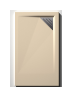

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1r7h3crzsna7ixqskbrfs8yerh6a con tipo MIME image/jpeg
✅ IMAGEN SELECCIONADA: 1/1
🎯 ¿Puede añadir cotas 3D?: NO
🔍 Confianza: 0.5
⭐ Puntuación de calidad: 9/10

📐 Dimensiones detectadas como visibles:
   • Longitud (lado largo): ✓
   • Anchura (lado corto): ✓
   • Grosor/Altura (espesor): ✗


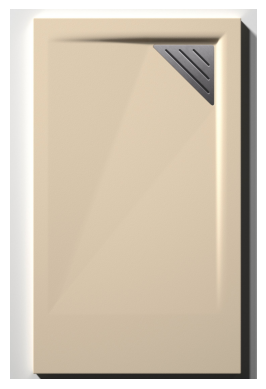

✅ Imagen selecionada para crear cotas desde https://media.adeo.com/media/qsi8uetrzxi1r7h3crzsna7ixqskbrfs8yerh6a

📤 Subiendo imagen a Google Drive...
✅ Carpeta 'Pruebas_plato_de_duchas_con_cotas' encontrada: 1H6u2SFq-Ft2TDFASxPMykV_NQ-FPJXA6
   📂 En unidad compartida: 0AD4cVfPueYs1Uk9PVA
   ✅ Imagen '84412446.png' subida correctamente
      📎 ID: 1pRuuhO5y0g-HiofgrKpCzXw1aYR0-RqW
      🔗 Ver: https://drive.google.com/file/d/1pRuuhO5y0g-HiofgrKpCzXw1aYR0-RqW/view?usp=drivesdk


In [189]:
selected_image = None

if images.empty:
    print(f"⚠️ No se encontraron imágenes para la referencia {reference}")
else:
    images_url = images['mediaLinkUrl'].tolist()
    image_parts = []
    images_bytes = []
    for idx, image_url in enumerate(images_url): 
        image_bytes, mime_type = download_image_from_url(image_url)
        
        if image_bytes:
            image = Image.open(BytesIO(image_bytes))
            images_bytes.append(image)
            # Display the image
            plt.figure(figsize=(1, 1))
            plt.imshow(image)
            plt.axis('off') # Hide the X and Y axes
            plt.show()
            
            # Agregar la imagen con su índice
            image_parts.append(Part.from_text(text=f"\n--- IMAGE {idx + 1} ---"))
            image_parts.append(Part.from_bytes(data=image_bytes, mime_type=mime_type))
            
            print(f"✅ Imagen descargada correctamente desde {image_url} con tipo MIME {mime_type}")

        else:
            print(f"⚠️ No se pudo descargar la imagen desde {image_url}")

    # Seleccionar la mejor imagen usando la función definida
    image_selection_result = get_better_image_to_add_pattern(image_parts, number_dimensions)
    selected_index = image_selection_result['selected_index']
    selected_image = images_bytes[selected_index]
    
    plt.imshow(selected_image)
    plt.axis('off') # Hide the X and Y axes
    plt.show()
    print(f"✅ Imagen selecionada para crear cotas desde {images_url[selected_index]}")


    # Save image in drive 
    if selected_image is not None:
        print(f"\n📤 Subiendo imagen a Google Drive...")
        
        parent_folder_id = get_drive_folder_id(DRIVE_FOLDER_NAME)

        if parent_folder_id:
            
            try:
                drive_file = upload_image_to_drive_from_memory(
                    image=selected_image,
                    file_name=f"{reference}.png",
                    folder_id=parent_folder_id
                )
            except Exception as e:
                print(f"❌ Error al subir imagen a Drive: {e}")
        else:
            print(f"❌ No se pudo encontrar la carpeta '{DRIVE_FOLDER_NAME}' en Google Drive")
    else:
        print("⚠️ No hay imagen seleccionada para subir a Drive")

## Generar pictograma


📐 Generando pictograma lineal a partir de la imagen seleccionada
Picto generado correctamente
✅ Pictograma extraída correctamente (parte 0)


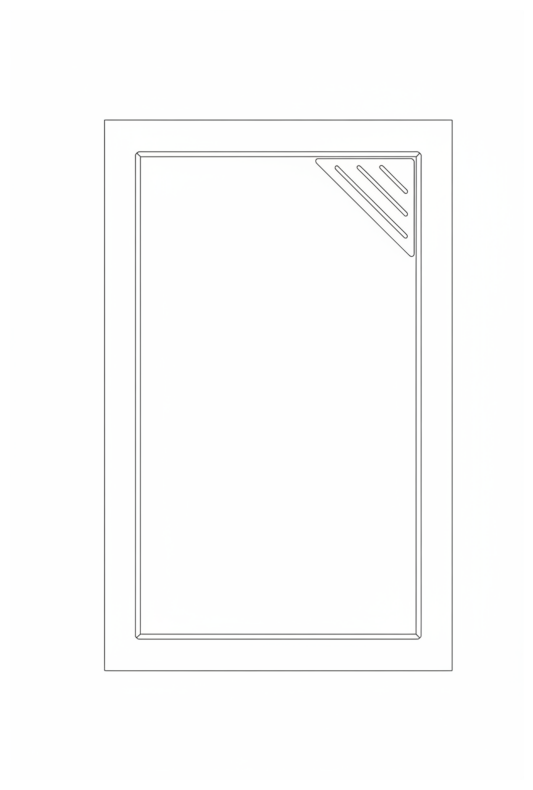

In [190]:
# Crear pictograma a partir de la imagen seleccionada
print(f"\n📐 Generando pictograma lineal a partir de la imagen seleccionada")
pictogram = get_pictogram_from_image(selected_image)

# Extraer imagen de forma segura
pictogram_image = extract_image_from_response(pictogram, "pictograma")

if pictogram_image:
    # Mostrar
    plt.figure(figsize=(8, 8))
    plt.imshow(pictogram_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # # Guardar en Drive
    # if subfolder_id:
    #     try:
    #         drive_file = upload_image_to_drive_from_memory(
    #             image=pictogram_image,
    #             file_name=f"{reference}-pictogram.png",
    #             folder_id=subfolder_id
    #         )
    #     except Exception as e:
    #         print(f"⚠️ No se pudo subir a Drive: {e}")
else:
    print("⚠️ No se pudo generar el pictograma. Verifica la respuesta de la API.")



## Añadir cotas segun las dimensios obtenidas


📐 Dimensiones detectadas como visibles:
   • Longitud: ✓
   • Anchura: ✓
   • Grosor: ✗
📏 AÑADIENDO COTAS TÉCNICAS (Estándar Leroy Merlin)
📐 Dimensiones totales disponibles: 2
📐 Dimensiones visibles en vista principal: 2
🖼️ Icono de grosor incluido: NO

✓ Dimensiones en la vista principal:
   • Longitud (lado largo): 90 cm
   • Anchura (lado corto): 90 cm
✅ Imagen con cotas referencia 84412446


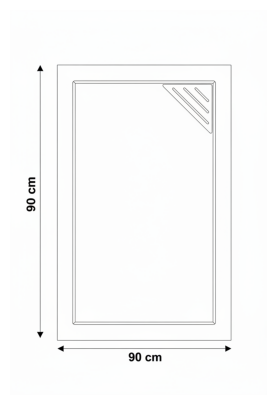

✅ Carpeta 'Pruebas_plato_de_duchas_con_cotas' encontrada: 1H6u2SFq-Ft2TDFASxPMykV_NQ-FPJXA6
   📂 En unidad compartida: 0AD4cVfPueYs1Uk9PVA
   ✅ Imagen '84412446-pat-ia-01.png' subida correctamente
      📎 ID: 1p1jtn6tO93WgovCRuw35UNIP6evVGHua
      🔗 Ver: https://drive.google.com/file/d/1p1jtn6tO93WgovCRuw35UNIP6evVGHua/view?usp=drivesdk


In [192]:
# Obtener las dimensiones visibles del resultado de selección de imagen
if image_selection_result.get('can_add_3d_dimensions'):
   visible_dims ={'length': True, 'width': True, 'thickness': True}
else:
    visible_dims = {'length': True, 'width': True, 'thickness': False}

print(f"\n📐 Dimensiones detectadas como visibles:")
print(f"   • Longitud: {'✓' if visible_dims.get('length') else '✗'}")
print(f"   • Anchura: {'✓' if visible_dims.get('width') else '✗'}")
print(f"   • Grosor: {'✓' if visible_dims.get('thickness') else '✗'}")

# Generar imagen con cotas usando solo las dimensiones visibles
response = get_dimensions_added_from_pictogram(
    dimensiones=dimensiones,
    image=pictogram_image,
    visible_dimensions=visible_dims,
    thickness_icon_image=thickness_icon
)

if response:
    print(f"✅ Imagen con cotas referencia {reference}")
else:
    print("⚠️ No se pudo generar la imagen con cotas")
    
# Extraer la imagen de la respuesta
if response and response.candidates:
    # Obtener la primera parte de la respuesta que contiene la imagen
    for part in response.candidates[0].content.parts:
        if part.inline_data:
            # Convertir los bytes de la imagen a PIL Image
            image_data = part.inline_data.data
            generated_image = Image.open(BytesIO(image_data))
            
            # Mostrar la imagen
            plt.figure(figsize=(5, 5))
            plt.imshow(generated_image)
            plt.axis('off') # Hide the X and Y axes
            plt.show()
            folder_path = Path(FOLDER_IMAGES) 
            file_path = folder_path / f"{reference}-pat-01.png"
            # Guardar la imagen
            generated_image.save(file_path)
            
            # Guardar drive 
            parent_folder_id = get_drive_folder_id(DRIVE_FOLDER_NAME)
            drive_file = upload_image_to_drive_from_memory(
                image=generated_image,
                file_name=f"{reference}-pat-ia-01.png",
                folder_id=parent_folder_id
            )